### Setup

In [9]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
from matplotlib import style
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import metrics
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format
style.use("seaborn-notebook")

### Load Dataset

In [2]:
california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

### Randomization

In [3]:
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
8587,-118.5,34.3,21.0,8850.0,2139.0,4717.0,1979.0,3.8,254.2
15639,-122.4,37.6,52.0,3084.0,595.0,1324.0,571.0,5.1,374.2
3614,-117.9,33.6,32.0,1997.0,427.0,944.0,426.0,4.4,500.0
1629,-117.2,32.9,25.0,4229.0,601.0,1634.0,574.0,6.4,316.7
4501,-118.0,33.9,34.0,1995.0,417.0,1573.0,407.0,3.5,153.5
...,...,...,...,...,...,...,...,...,...
15251,-122.3,37.5,44.0,3022.0,473.0,1235.0,477.0,6.7,495.9
16191,-122.5,37.7,27.0,2447.0,720.0,2104.0,657.0,3.4,239.1
15685,-122.4,37.3,33.0,1054.0,209.0,400.0,161.0,7.8,456.3
9191,-119.0,35.3,20.0,37.0,11.0,34.0,8.0,1.2,50.0


### Examine the Statistics

In [4]:
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


### Input Function

In [5]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key: np.array(value) for key, value in dict(features).items()}
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

### Train Model Function

In [6]:
def train_model(learning_rate, steps, batch_size, input_feature="total_rooms"):
    periods = 10
    steps_per_period = steps / periods
    my_feature = input_feature
    my_feature_data = california_housing_dataframe[[my_feature]]
    my_label = "median_house_value"
    targets = california_housing_dataframe[my_label]
    
    # Create feature_columns
    feature_columns = [tf.feature_column.numeric_column(my_feature)]
    
    # Create input functions
    training_input_fn = lambda: my_input_fn(my_feature_data, targets, batch_size=batch_size)
    prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
    
    # Create linear_regressor object
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns = feature_columns,
        optimizer = my_optimizer
    )
    
    # Setup to plot the state of our model's line each period
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.title("Learning Line by Period\n")
    plt.xlabel(my_feature)
    plt.ylabel(my_label)
    sample = california_housing_dataframe.sample(n=300)
    plt.scatter(sample[my_feature], sample[my_label])
    colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]
    
    # Train the model inside the loop
    print("Trainig model...")
    print("RMSE (on Trainig data)")
    root_mean_squared_errors = []
    for period in range(0, periods):
        # Train the model starting from prior state
        linear_regressor.train(
            input_fn = training_input_fn,
            steps = steps_per_period
        )
        
        # Take a break and compute predictions
        predictions = linear_regressor.predict(input_fn=prediction_input_fn)
        predictions = np.array([item['predictions'][0] for item in predictions])
        
        # Compute loss
        root_mean_squared_error = math.sqrt(metrics.mean_squared_error(predictions, targets))
        print("  Period %02d : %0.2f" % (period, root_mean_squared_error))
        root_mean_squared_errors.append(root_mean_squared_error)
        
        # Weights and bias
        y_extents = np.array([0, sample[my_label].max()])
        weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
        bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
        x_extents = (y_extents - bias) / weight
        x_extents = np.maximum(np.minimum(x_extents, sample[my_feature].max()), sample[my_feature].min())
        y_extents = weight * x_extents + bias
        plt.plot(x_extents, y_extents, color=colors[period])
    print("Model training finished.")
    
    # Output the graph of loss metrics over periods
    plt.subplot(1, 2, 2)
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods\n")
    plt.tight_layout()
    plt.plot(root_mean_squared_errors)
    plt.show()
    print("Final RMSE (on training data): %s" % root_mean_squared_errors[-1])
    
    # Output the table with Calibration data
    calibration_data = pd.DataFrame()
    calibration_data["Predictions"] = pd.Series(predictions)
    calibration_data["Targets"] = pd.Series(targets)
    display.display(calibration_data.describe())

Trainig model...
RMSE (on Trainig data)
  Period 00 : 225.63
  Period 01 : 214.42
  Period 02 : 204.04
  Period 03 : 195.69
  Period 04 : 187.55
  Period 05 : 181.07
  Period 06 : 175.44
  Period 07 : 171.40
  Period 08 : 168.72
  Period 09 : 167.45
Model training finished.


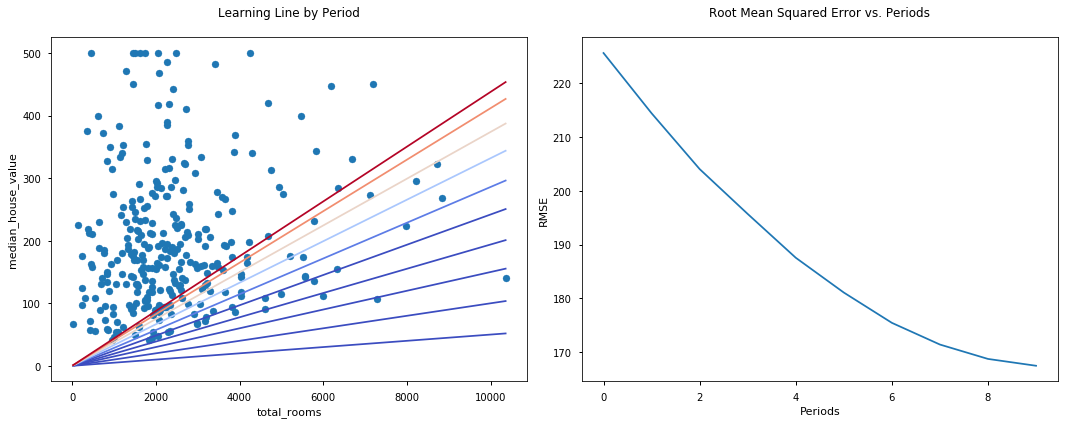

Final RMSE (on training data): 167.4523966940849


,Predictions,Targets
count,17000.0,17000.0
mean,115.8,207.3
std,95.5,116.0
min,0.1,15.0
25%,64.0,119.4
50%,93.2,180.4
75%,138.0,265.0
max,1661.6,500.0


In [8]:
train_model(
    learning_rate=0.00002,
    steps=500,
    batch_size=5
)